In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
from tqdm.auto import tqdm
from collections import Counter

tqdm.pandas()

## Definitions

1. [ ] Define input and output
 - Input: sequence of code tokens, where token to predict is <UNK>
 - Output: a list of predicted tokens, sorted in descending order of probability
1. [ ] Define evaluation metric
 - Should be rank-aware, e.g. MRR, MAP, NDCG.
 - The target token is split into subtokens and the overlap between the predicted token and the target token at subtoken level is evaluated. This can be done with an F1 score.
    - For example, if `transformSearchResponse` is the target token, its subtokens are `transform`, `search` and `response`. If the predicted token is `modifySearchResponse`, then the overlap is 2 subtokens out of 3.
    - [ ] Should we account for the order of the subtokens? Most probably, yes.
    ```
    Precision = TP / (TP + FP) = #overlapping-predicted / (#overlapping-predicted + #nonoverlapping-predicted)
    Recall = TP / (TP + FN) = #overlapping-predicted / (#overlapping-predicted + #nonoverlapping-required)
    F1 = 2 * P * R / (P + R)
    ```
 - The F1 approach is inspired by SQuAD and "Suggesting accurate method and class names" by Allamanis et al.

## Execution Tasks

1. [ ] Gather Data
1. [ ] Analyze Data
1. [ ] Implement an algorithm
1. [ ] Create an evaluation loop
1. [ ] Expose parameters of the algorithm
1. [ ] Make experiments
1. [ ] Document the experiments - Hypothesis, Data, Setup, Evaluation, Algorithm, Experiments, Conclusion, Further Steps



## Discussion
it isn't as simple as, jsut average some word embeddings
it is easy to average the embeddings if you need to predict a word
but i have to predict a an unknown amount of subtokens

well, why don't we try to predict subtoken at a time
but what type should it be?
well, we can split all tokens into subtokens and count the PoS occurrences
so that we know a few patterns upfront
and use these patterns to fill in the subtokens with averaged word embeddings
similar to the context we have, but filtered according to the PoS tag
this is an interesting idea, because we do suggestion at the subtoken level
i like this idea and we can try it

of course the other idea is to use source code embeddings directly
but they have to be learned on our source code base
and this is a separate problem
which involves learning a model
which is what we try to avoid with our simplistic baseline
we are just exploring ideas
a baseline without learning might be a failure
but the ideas we try and pick up during the design and experimentation are what is most valuable



In [2]:
def split_by_camel_case(token):
#     TODO: implement me
    return token

def get_subtokens(token):
    return split_by_camel_case(token)

def compute_f1(target_token, predicted_token):
    target_subtokens = get_subtokens(target_token)
    predicted_subtokens = get_subtokens(predicted_token)
    overlapping = Counter(target_subtokens) & Counter(predicted_subtokens)
    overlapping_count = sum(overlapping.values())
    
    precision = 1.0 * overlapping_count / len(predicted_subtokens)
    recall = 1.0 * overlapping_count / len(target_subtokens)
    f1 = (2.0 * precision * recall) / (precision + recall)
    return f1

In [3]:
compute_f1(['transform', 'search', 'response'], ['modify', 'search', 'response', 'data'])

0.5714285714285715

In [4]:
df = pd.read_csv('../data/method-names/elastic-search-clean.csv', delimiter=';')
df

,file,id,type
0,/buildSrc/src/test/java/org/elasticsearch/grad...,testInvalidBlockQuote,void
1,/buildSrc/src/test/java/org/elasticsearch/grad...,testSimpleBlockQuote,void
2,/buildSrc/src/test/java/org/elasticsearch/grad...,testMultipleBlockQuotes,void
3,/buildSrc/src/test/java/org/elasticsearch/grad...,testEscapingInBlockQuote,void
4,/buildSrc/src/test/java/org/elasticsearch/grad...,testIsDocWriteRequest,void
...,...,...,...
115630,/plugins/repository-s3/src/main/java/org/elast...,refine,S3ClientSettings
115631,/plugins/repository-s3/src/main/java/org/elast...,load,"Map<String, S3ClientSettings>"
115632,/plugins/repository-s3/src/main/java/org/elast...,loadCredentials,S3BasicCredentials
115633,/plugins/repository-s3/src/main/java/org/elast...,getClientSettings,S3ClientSettings


In [5]:
def camel_case_split(str):
    words = [[str[0]]]
  
    for c in str[1:]: 
        if words[-1][-1].islower() and c.isupper(): 
            words.append(list(c)) 
        else: 
            words[-1].append(c) 
  
    return [''.join(word) for word in words] 

In [70]:
df_id = df['id'] \
    .progress_apply(camel_case_split) \
    .progress_apply(lambda identifier: [word.lower() for word in identifier]) \

df_id

0              [test, invalid, block, quote]
1               [test, simple, block, quote]
2            [test, multiple, block, quotes]
3         [test, escaping, in, block, quote]
4            [test, is, doc, write, request]
                         ...                
115630                              [refine]
115631                                [load]
115632                   [load, credentials]
115633               [get, client, settings]
115634                              [equals]
Name: id, Length: 115635, dtype: object


 15%|█▍        | 17151/115635 [01:50<09:35, 171.03it/s]

100%|██████████| 115635/115635 [00:00<00:00, 879848.09it/s]

max_subtoken_count = 23


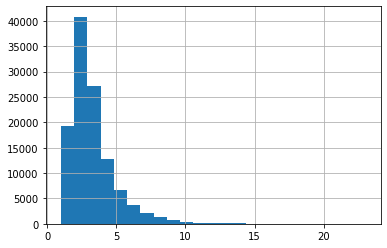

In [12]:
# count how many subtokens there are inside identifiers
df_lengths = df_id.progress_apply(len)
max_subtoken_count = df_lengths.max()
print('max_subtoken_count = {}'.format(max_subtoken_count))

df_lengths.hist(bins=max_subtoken_count)

In [8]:
!python -m spacy download en_core_web_sm

You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [9]:
import en_core_web_sm
nlp = en_core_web_sm.load()

doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

Apple Apple PROPN NNP nsubj Xxxxx True False
is be AUX VBZ aux xx True True
looking look VERB VBG ROOT xxxx True False
at at ADP IN prep xx True True
buying buy VERB VBG pcomp xxxx True False
U.K. U.K. PROPN NNP compound X.X. False False
startup startup NOUN NN dobj xxxx True False
for for ADP IN prep xxx True True
$ $ SYM $ quantmod $ False False
1 1 NUM CD compound d False False
billion billion NUM CD pobj xxxx True False


In [71]:
def split_into_pos_tags(tokens):
    identifier = nlp(' '.join(tokens))
    return list(map(lambda x: (x[0], x[1].tag_), enumerate(identifier)))

pos_tags_with_position = df_id \
    .progress_apply(split_into_pos_tags) \
    .sum()

df_pos = pd.DataFrame(pos_tags_with_position, columns=['position', 'tag']) \
    .groupby(['position', 'tag']).size() \
    .reset_index() \
    .rename(columns={0: 'count'})
df_pos

,position,tag,count
0,0,$,1
1,0,",",1
2,0,.,17
3,0,:,10
4,0,ADD,26
...,...,...,...
474,20,NN,1
475,21,JJ,1
476,21,NN,2
477,21,VBN,1


In [73]:
df_pos[df_pos['position'] == 0].sort_values(by='count', ascending=False)

,position,tag,count
26,0,VB,40906
17,0,NNP,26846
16,0,NN,24398
9,0,IN,6455
10,0,JJ,4826
19,0,NNS,4087
31,0,VBZ,2468
24,0,TO,1662
29,0,VBN,1282
30,0,VBP,670


In [5]:
df_pos_filename = '../data/analysis/elastic-search/pos_tag_count_at_position.csv'
df_pos.to_csv(df_pos_filename)

NameError: name 'df_pos' is not defined

In [76]:
df_pos = pd.read_csv(df_pos_filename, index_col=0)
df_pos

,position,tag,count
0,0,$,1
1,0,",",1
2,0,.,17
3,0,:,10
4,0,ADD,26
...,...,...,...
474,20,NN,1
475,21,JJ,1
476,21,NN,2
477,21,VBN,1


In [80]:
df_pos_table = df_pos \
    .sort_values(by=['count']) \
    .pivot(index='tag', columns='position', values='count') \
    .fillna(0)

df_pos_table = df_pos_table.reindex(df_pos_table[0].sort_values(ascending=False).index)
#     .head(15)[range(0, 10)] # TODO: remove outliers

df_pos_table

position,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
tag,,,,,,,,,,,,,,,,,,,,,
VB,40906.0,5874.0,1043.0,494.0,353.0,245.0,153.0,75.0,42.0,25.0,...,2.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
NNP,26846.0,22361.0,6891.0,2236.0,1035.0,608.0,345.0,190.0,90.0,53.0,...,23.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NN,24398.0,32937.0,24520.0,12375.0,6057.0,3096.0,1775.0,1066.0,646.0,383.0,...,28.0,26.0,8.0,7.0,3.0,4.0,4.0,1.0,2.0,3.0
IN,6455.0,5058.0,4100.0,2881.0,1787.0,995.0,494.0,306.0,137.0,77.0,...,9.0,1.0,3.0,2.0,0.0,1.0,0.0,3.0,0.0,0.0
JJ,4826.0,11405.0,3780.0,2030.0,1328.0,835.0,565.0,316.0,206.0,106.0,...,7.0,5.0,4.0,2.0,2.0,2.0,1.0,1.0,1.0,0.0
NNS,4087.0,6481.0,7309.0,3435.0,1823.0,1072.0,591.0,362.0,210.0,124.0,...,9.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
VBZ,2468.0,834.0,719.0,579.0,463.0,258.0,149.0,88.0,75.0,26.0,...,5.0,2.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0
TO,1662.0,271.0,156.0,94.0,62.0,22.0,28.0,9.0,7.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VBN,1282.0,2372.0,1655.0,862.0,615.0,437.0,273.0,203.0,94.0,57.0,...,2.0,2.0,3.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0


In [91]:
df_pos_table_sum_by_position = df_pos_table.sum(axis=0)
df_pos_table_sum_by_position

position
0     115635.0
1      96486.0
2      56038.0
3      28836.0
4      15689.0
5       8939.0
6       5268.0
7       3142.0
8       1817.0
9       1044.0
10       589.0
11       335.0
12       192.0
13       112.0
14        53.0
15        31.0
16        19.0
17        12.0
18         9.0
19         7.0
20         5.0
21         4.0
22         3.0
dtype: float64

In [105]:
df_subtoken_count_prob = df_pos_table_sum_by_position / df_pos_table_sum_by_position.sum()
df_subtoken_count_prob

position
0     0.345938
1     0.288651
2     0.167645
3     0.086267
4     0.046936
5     0.026742
6     0.015760
7     0.009400
8     0.005436
9     0.003123
10    0.001762
11    0.001002
12    0.000574
13    0.000335
14    0.000159
15    0.000093
16    0.000057
17    0.000036
18    0.000027
19    0.000021
20    0.000015
21    0.000012
22    0.000009
dtype: float64

In [106]:
df_pos_table_percentage = (df_pos_table / df_pos_table_sum_by_position) * df_subtoken_count_prob
df_pos_table_percentage

position,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
tag,,,,,,,,,,,,,,,,,,,,,
VB,0.122376,0.017573,0.003120,0.001478,0.001056,0.000733,0.000458,0.000224,0.000126,0.000075,...,0.000006,0.000000,0.000003,0.000006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NNP,0.080314,0.066896,0.020615,0.006689,0.003096,0.001819,0.001032,0.000568,0.000269,0.000159,...,0.000069,0.000000,0.000015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NN,0.072990,0.098536,0.073355,0.037022,0.018120,0.009262,0.005310,0.003189,0.001933,0.001146,...,0.000084,0.000078,0.000024,0.000021,0.000009,0.000012,0.000012,0.000003,0.000006,0.000009
IN,0.019311,0.015132,0.012266,0.008619,0.005346,0.002977,0.001478,0.000915,0.000410,0.000230,...,0.000027,0.000003,0.000009,0.000006,0.000000,0.000003,0.000000,0.000009,0.000000,0.000000
JJ,0.014438,0.034120,0.011308,0.006073,0.003973,0.002498,0.001690,0.000945,0.000616,0.000317,...,0.000021,0.000015,0.000012,0.000006,0.000006,0.000006,0.000003,0.000003,0.000003,0.000000
NNS,0.012227,0.019389,0.021866,0.010276,0.005454,0.003207,0.001768,0.001083,0.000628,0.000371,...,0.000027,0.000006,0.000003,0.000003,0.000003,0.000003,0.000000,0.000000,0.000000,0.000000
VBZ,0.007383,0.002495,0.002151,0.001732,0.001385,0.000772,0.000446,0.000263,0.000224,0.000078,...,0.000015,0.000006,0.000006,0.000003,0.000006,0.000000,0.000000,0.000000,0.000000,0.000000
TO,0.004972,0.000811,0.000467,0.000281,0.000185,0.000066,0.000084,0.000027,0.000021,0.000015,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
VBN,0.003835,0.007096,0.004951,0.002579,0.001840,0.001307,0.000817,0.000607,0.000281,0.000171,...,0.000006,0.000006,0.000009,0.000000,0.000003,0.000003,0.000003,0.000000,0.000003,0.000000


In [122]:
df_filtered = df_pos_table_percentage.round(3)
df_pos_table_percentage_clean = df_filtered[df_filtered > 0].dropna(axis=0, how='all').dropna(axis=1, how='all').fillna(0)
df_pos_table_percentage_clean

position,0,1,2,3,4,5,6,7,8,9,10
tag,,,,,,,,,,,
VB,0.122,0.018,0.003,0.001,0.001,0.001,0.000,0.000,0.000,0.000,0.000
NNP,0.080,0.067,0.021,0.007,0.003,0.002,0.001,0.001,0.000,0.000,0.000
NN,0.073,0.099,0.073,0.037,0.018,0.009,0.005,0.003,0.002,0.001,0.001
IN,0.019,0.015,0.012,0.009,0.005,0.003,0.001,0.001,0.000,0.000,0.000
JJ,0.014,0.034,0.011,0.006,0.004,0.002,0.002,0.001,0.001,0.000,0.000
NNS,0.012,0.019,0.022,0.010,0.005,0.003,0.002,0.001,0.001,0.000,0.000
VBZ,0.007,0.002,0.002,0.002,0.001,0.001,0.000,0.000,0.000,0.000,0.000
TO,0.005,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
VBN,0.004,0.007,0.005,0.003,0.002,0.001,0.001,0.001,0.000,0.000,0.000


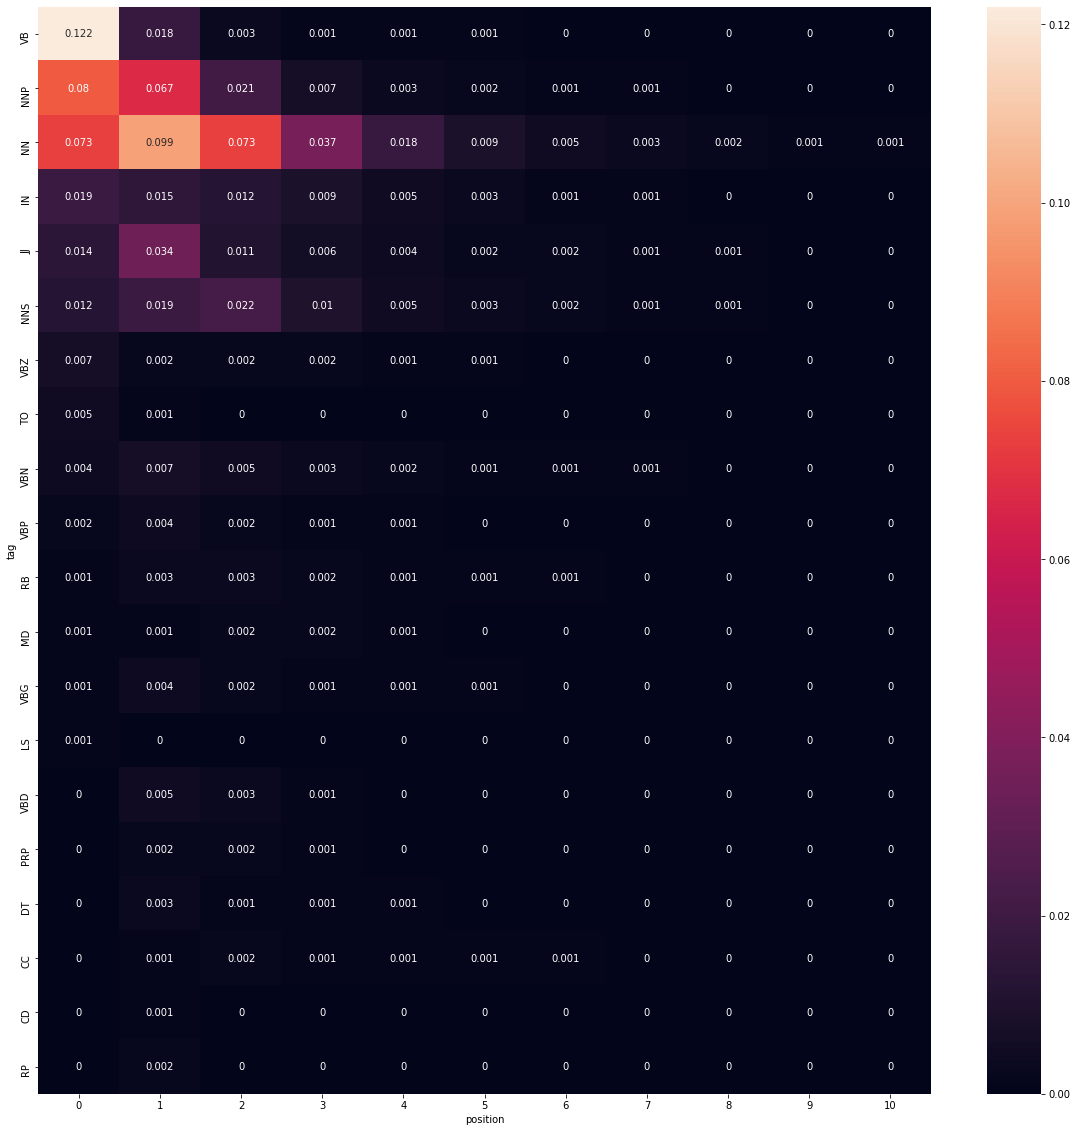

In [125]:
plt.figure(figsize=(20, 20))
sns.heatmap(df_pos_table_percentage_clean, annot=True, fmt='g')